In [1]:
print(r'https://juanitorduz.github.io/germany_plots/')

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm.notebook import tqdm, trange
import os
import shutil
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gc

#%matplotlib inline

pd.set_option('display.max_columns', None)

import matplotlib
matplotlib.rc('font', size=24) 
matplotlib.rc('font', size=16)          # controls default text sizes


https://juanitorduz.github.io/germany_plots/


In [2]:
shape_df = gpd.read_file('VG250_LAN.shp') 
shape_df=shape_df.drop(shape_df.index[[33,34]])
shape_df.head()

,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,BEM,NBD,SN_L,SN_R,SN_K,SN_V1,SN_V2,SN_G,FK_S3,NUTS,ARS_0,AGS_0,WSK,DEBKG_ID,RS,SDV_RS,RS_0,geometry
0,2,4,1,01,01,010020000000,Schleswig-Holstein,Land,20,--,ja,01,0,00,00,00,000,0,DEF,010000000000,01000000,2012-02-01,DEBKGDL200000029,01,010020000000,010000000000,"MULTIPOLYGON (((3464863.775 6102446.269, 34649..."
1,2,4,1,02,02,020000000000,Hamburg,Freie und Hansestadt,22,--,ja,02,0,00,00,00,000,0,DE6,020000000000,02000000,1974-01-01,DEBKGDL20000E6GD,02,020000000000,020000000000,"MULTIPOLYGON (((3578320.324 5956221.807, 35785..."
2,2,4,1,03,03,032410001001,Niedersachsen,Land,20,--,ja,03,0,00,00,00,000,0,DE9,030000000000,03000000,2015-01-01,DEBKGDL20000E6EW,03,032410001001,030000000000,"MULTIPOLYGON (((3479512.889 5973250.388, 34794..."
3,2,4,1,04,04,040110000000,Bremen,Freie Hansestadt,23,--,ja,04,0,00,00,00,000,0,DE5,040000000000,04000000,2010-01-01,DEBKGDL20000E0SF,04,040110000000,040000000000,"MULTIPOLYGON (((3466988.203 5899769.937, 34670..."
4,2,4,1,05,05,051110000000,Nordrhein-Westfalen,Land,20,--,ja,05,0,00,00,00,000,0,DEA,050000000000,05000000,2009-11-01,DEBKGDL20000E6GR,05,051110000000,050000000000,"MULTIPOLYGON (((3477670.596 5820656.545, 34777..."


In [3]:
path = 'RKI_COVID19_2021_01_05.csv'
data = pd.read_csv(path)

data['Meldedatum']= pd.to_datetime(data['Meldedatum'])
data['Refdatum']= pd.to_datetime(data['Refdatum'])
akt_date=pd.to_datetime(data["Datenstand"][0],format="%d.%m.%Y, %M:%H Uhr")

In [4]:
def datum(df,date,tage,melde=True,return_date=False):
    #returnd Fälle von Datum(inkl) bis Datum-Tage(inkl)
    #bsp: datum(df=data_wup,date="2020/9/25",tage=2)
    end_date=pd.to_datetime(date)-pd.DateOffset(days=1)
    start_date=end_date-pd.DateOffset(days=tage)
    if melde:
        mask = (df['Meldedatum'] > start_date) & (df['Meldedatum'] <  end_date) | (df['Meldedatum'] == end_date)
    else:
        mask = (df['Refdatum'] > start_date) & (df['Refdatum'] <  end_date) | (df['Refdatum'] == end_date)
    if return_date:
        return df.loc[mask],start_date,end_date
    else:
        return df.loc[mask]


data.Bundesland.unique()

array(['Schleswig-Holstein', 'Hamburg', 'Niedersachsen', 'Bremen',
       'Nordrhein-Westfalen', 'Hessen', 'Rheinland-Pfalz',
       'Baden-Württemberg', 'Bayern', 'Saarland', 'Berlin', 'Brandenburg',
       'Mecklenburg-Vorpommern', 'Sachsen', 'Sachsen-Anhalt', 'Thüringen'],
      dtype=object)

In [5]:
einwohner = {

"Nordrhein-Westfalen":17947,
"Bayern":13125,
"Baden-Württemberg":11100,
"Niedersachsen":7994,
"Hessen":6288,
"Rheinland-Pfalz":4094,
"Sachsen":4072,
"Berlin":3669,
"Schleswig-Holstein":2904,
"Brandenburg":2522,
"Sachsen-Anhalt":2195,
"Thüringen":2133,
"Hamburg":1847,
"Mecklenburg-Vorpommern":1608,
"Saarland":987,
"Bremen":681
}

In [6]:
def gen_geo_Data(geoDaten,RKI_Corona_Daten,Tage_Zurück,Start_Datum=akt_date):
    datum_list=[]
    Bundeslaender=RKI_Corona_Daten.Bundesland.unique()
    max_faelle=0
    for i in range(Tage_Zurück):
        date=Start_Datum-pd.DateOffset(days=i+1)
        datum_list.append(date)
        data_bund_datum=RKI_Corona_Daten.loc[data['Meldedatum']==date]

        liste_faelle=[]
        for Bundesland in Bundeslaender:        
            data_land_datum=data_bund_datum.loc[data_bund_datum['Bundesland']==Bundesland]
            liste_faelle.append(data_land_datum['AnzahlFall'].sum(axis = 0, skipna = True))
        Bundeslaender_faelle=pd.Series(liste_faelle,index=Bundeslaender)
        geoDaten[date]=np.array([Bundeslaender_faelle[x] for x in np.array(geoDaten["GEN"])])
        
        max_faelle=max(max_faelle,Bundeslaender_faelle.max())
    return datum_list,Bundeslaender,geoDaten,max_faelle
datum_list,Bundeslaender,geoDaten,max_faelle=gen_geo_Data(shape_df,data,30)
geoDaten.head()

,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,BEM,NBD,SN_L,SN_R,SN_K,SN_V1,SN_V2,SN_G,FK_S3,NUTS,ARS_0,AGS_0,WSK,DEBKG_ID,RS,SDV_RS,RS_0,geometry,2021-01-04 00:00:00,2021-01-03 00:00:00,2021-01-02 00:00:00,2021-01-01 00:00:00,2020-12-31 00:00:00,2020-12-30 00:00:00,2020-12-29 00:00:00,2020-12-28 00:00:00,2020-12-27 00:00:00,2020-12-26 00:00:00,2020-12-25 00:00:00,2020-12-24 00:00:00,2020-12-23 00:00:00,2020-12-22 00:00:00,2020-12-21 00:00:00,2020-12-20 00:00:00,2020-12-19 00:00:00,2020-12-18 00:00:00,2020-12-17 00:00:00,2020-12-16 00:00:00,2020-12-15 00:00:00,2020-12-14 00:00:00,2020-12-13 00:00:00,2020-12-12 00:00:00,2020-12-11 00:00:00,2020-12-10 00:00:00,2020-12-09 00:00:00,2020-12-08 00:00:00,2020-12-07 00:00:00,2020-12-06 00:00:00
0,2,4,1,01,01,010020000000,Schleswig-Holstein,Land,20,--,ja,01,0,00,00,00,000,0,DEF,010000000000,01000000,2012-02-01,DEBKGDL200000029,01,010020000000,010000000000,"MULTIPOLYGON (((3464863.775 6102446.269, 34649...",232,207,266,133,359,465,576,268,188,201,177,365,671,586,277,194,437,553,488,516,496,211,143,439,429,460,341,356,177,119
1,2,4,1,02,02,020000000000,Hamburg,Freie und Hansestadt,22,--,ja,02,0,00,00,00,000,0,DE6,020000000000,02000000,1974-01-01,DEBKGDL20000E6GD,02,020000000000,020000000000,"MULTIPOLYGON (((3578320.324 5956221.807, 35785...",0,57,241,201,301,582,495,489,153,250,212,339,541,630,624,221,377,583,549,494,534,320,293,290,513,457,457,348,270,254
2,2,4,1,03,03,032410001001,Niedersachsen,Land,20,--,ja,03,0,00,00,00,000,0,DE9,030000000000,03000000,2015-01-01,DEBKGDL20000E6EW,03,032410001001,030000000000,"MULTIPOLYGON (((3479512.889 5973250.388, 34794...",351,357,572,511,1427,2165,1657,887,339,460,818,1433,2012,1648,1220,481,1379,1536,1744,1958,1275,883,420,1178,1268,1679,1439,1112,842,279
3,2,4,1,04,04,040110000000,Bremen,Freie Hansestadt,23,--,ja,04,0,00,00,00,000,0,DE5,040000000000,04000000,2010-01-01,DEBKGDL20000E0SF,04,040110000000,040000000000,"MULTIPOLYGON (((3466988.203 5899769.937, 34670...",54,37,11,23,109,155,157,61,38,33,34,79,248,123,49,130,103,123,157,223,131,21,56,171,121,185,209,119,46,57
4,2,4,1,05,05,051110000000,Nordrhein-Westfalen,Land,20,--,ja,05,0,00,00,00,000,0,DEA,050000000000,05000000,2009-11-01,DEBKGDL20000E6GR,05,051110000000,050000000000,"MULTIPOLYGON (((3477670.596 5820656.545, 34777...",1724,1819,1856,1702,3157,5808,4896,2614,2322,2059,2245,3823,6759,5580,4083,2972,4404,5947,6214,6177,5190,3727,2522,4112,5845,5807,5299,4530,3378,2065


In [7]:
def gen_geo_Data_week(geoDaten,RKI_Corona_Daten,Tage_Zurück,Start_Datum=akt_date,scale=False):
    datum_list=[]
    Bundeslaender=RKI_Corona_Daten.Bundesland.unique()
    max_faelle=0
    for i in range(Tage_Zurück):
        date=Start_Datum-pd.DateOffset(days=i+1)
        datum_list.append(date)
        mask = (RKI_Corona_Daten['Meldedatum'] > date-pd.DateOffset(days=7)) & (RKI_Corona_Daten['Meldedatum'] <= date)
        data_bund_datum=RKI_Corona_Daten.loc[mask]

        liste_faelle=[]
        for Bundesland in Bundeslaender:        
            data_land_datum=data_bund_datum.loc[data_bund_datum['Bundesland']==Bundesland]
            if scale:
                liste_faelle.append(data_land_datum['AnzahlFall'].sum(axis = 0, skipna = True)*(100000/(einwohner[Bundesland]*1000)))
            else:
                liste_faelle.append(data_land_datum['AnzahlFall'].sum(axis = 0, skipna = True))
        Bundeslaender_faelle=pd.Series(liste_faelle,index=Bundeslaender)
        geoDaten[date]=np.array([Bundeslaender_faelle[x] for x in np.array(geoDaten["GEN"])])
        
        max_faelle=max(max_faelle,Bundeslaender_faelle.max())
    return datum_list,Bundeslaender,geoDaten,max_faelle
datum_list_week,Bundeslaender_week,geoDaten_week,max_faelle_week=gen_geo_Data_week(shape_df,data,30,scale=True)
geoDaten_week.head()

,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,BEM,NBD,SN_L,SN_R,SN_K,SN_V1,SN_V2,SN_G,FK_S3,NUTS,ARS_0,AGS_0,WSK,DEBKG_ID,RS,SDV_RS,RS_0,geometry,2021-01-04 00:00:00,2021-01-03 00:00:00,2021-01-02 00:00:00,2021-01-01 00:00:00,2020-12-31 00:00:00,2020-12-30 00:00:00,2020-12-29 00:00:00,2020-12-28 00:00:00,2020-12-27 00:00:00,2020-12-26 00:00:00,2020-12-25 00:00:00,2020-12-24 00:00:00,2020-12-23 00:00:00,2020-12-22 00:00:00,2020-12-21 00:00:00,2020-12-20 00:00:00,2020-12-19 00:00:00,2020-12-18 00:00:00,2020-12-17 00:00:00,2020-12-16 00:00:00,2020-12-15 00:00:00,2020-12-14 00:00:00,2020-12-13 00:00:00,2020-12-12 00:00:00,2020-12-11 00:00:00,2020-12-10 00:00:00,2020-12-09 00:00:00,2020-12-08 00:00:00,2020-12-07 00:00:00,2020-12-06 00:00:00
0,2,4,1,01,01,010020000000,Schleswig-Holstein,Land,20,--,ja,01,0,00,00,00,000,0,DEF,010000000000,01000000,2012-02-01,DEBKGDL200000029,01,010020000000,010000000000,"MULTIPOLYGON (((3464863.775 6102446.269, 34649...",77.066116,78.305785,77.651515,75.413223,76.928375,77.134986,84.228650,84.573003,84.882920,85.089532,93.216253,106.163912,110.399449,105.061983,101.962810,99.690083,97.933884,98.002755,93.732782,92.768595,86.742424,81.921488,80.750689,79.924242,73.760331,68.319559,61.260331,59.194215,53.994490,51.652893
1,2,4,1,02,02,020000000000,Hamburg,Freie und Hansestadt,22,--,ja,02,0,00,00,00,000,0,DE6,020000000000,02000000,1974-01-01,DEBKGDL20000E6GD,02,020000000000,020000000000,"MULTIPOLYGON (((3578320.324 5956221.807, 35785...",101.624256,128.099621,133.297239,133.784515,134.380076,136.437466,134.217650,141.526800,148.835950,152.517596,159.393611,179.480238,190.850027,188.305360,183.107742,166.648619,170.546833,165.836492,162.046562,157.065512,155.062263,144.991879,142.284786,140.173254,135.354629,126.800217,128.586898,119.599350,119.003790,121.007038
2,2,4,1,03,03,032410001001,Niedersachsen,Land,20,--,ja,03,0,00,00,00,000,0,DE9,030000000000,03000000,2015-01-01,DEBKGDL20000E6EW,03,032410001001,030000000000,"MULTIPOLYGON (((3479512.889 5973250.388, 34794...",88.066050,94.771078,94.545909,93.144859,96.985239,97.060295,95.146360,95.033775,99.199400,100.975732,112.471854,121.453590,125.344008,124.668501,120.002502,115.786840,115.023768,112.509382,109.156868,108.343758,101.851389,99.812359,99.299475,97.535652,94.145609,91.731298,87.953465,86.815111,85.539154,82.274206
3,2,4,1,04,04,040110000000,Bremen,Freie Hansestadt,23,--,ja,04,0,00,00,00,000,0,DE5,040000000000,04000000,2010-01-01,DEBKGDL20000E0SF,04,040110000000,040000000000,"MULTIPOLYGON (((3466988.203 5899769.937, 34670...",80.176211,81.204112,81.350954,84.581498,86.196769,81.791483,95.447871,90.455213,88.693098,102.202643,112.481645,125.550661,137.004405,133.333333,134.508076,130.396476,119.530103,129.515419,129.221733,133.333333,131.277533,129.515419,133.186490,133.333333,126.872247,128.634361,113.215859,107.048458,113.215859,111.160059
4,2,4,1,05,05,051110000000,Nordrhein-Westfalen,Land,20,--,ja,05,0,00,00,00,000,0,DEA,050000000000,05000000,2009-11-01,DEBKGDL20000E6GR,05,051110000000,050000000000,"MULTIPOLYGON (((3477670.596 5820656.545, 34777...",116.799465,121.758511,124.561208,125.692316,128.717892,132.428818,137.727754,141.538976,149.724188,153.345963,166.412214,187.039617,200.362178,197.119296,194.946231,192.962612,190.455229,188.828216,188.259876,185.992088,181.099905,177.422410,175.477796,172.931409,168.897309,161.442024,155.686187,153.223380,149.635036,145.840530


In [8]:
def gen_bund_Data_week(RKI_Corona_Daten,Tage_Zurück,Start_Datum=akt_date):
    datum_list=[]
    liste_faelle=[]
    for i in range(Tage_Zurück):
        date=Start_Datum-pd.DateOffset(days=i+1)
        datum_list.append(date)
        mask = (RKI_Corona_Daten['Meldedatum'] > date-pd.DateOffset(days=7)) & (RKI_Corona_Daten['Meldedatum'] <= date)
        data_bund_datum=RKI_Corona_Daten.loc[mask]
        liste_faelle.append(data_bund_datum['AnzahlFall'].sum(axis = 0, skipna = True)*(100000/(83020000)))
    bund_week=pd.Series(liste_faelle,index=datum_list)
    return bund_week
gen_bund_Data_week(data,30)

2021-01-04    134.722958
2021-01-03    144.918092
2021-01-02    146.756203
2021-01-01    149.065285
2020-12-31    152.772826
2020-12-30    155.108408
2020-12-29    158.936401
2020-12-28    160.945555
2020-12-27    166.418935
2020-12-26    171.358709
2020-12-25    183.548543
2020-12-24    203.370272
2020-12-23    216.371959
2020-12-22    213.481089
2020-12-21    210.955192
2020-12-20    209.626596
2020-12-19    207.936642
2020-12-18    206.746567
2020-12-17    203.836425
2020-12-16    200.396290
2020-12-15    195.914238
2020-12-14    191.135871
2020-12-13    188.022163
2020-12-12    185.327632
2020-12-11    179.376054
2020-12-10    173.429294
2020-12-09    167.870393
2020-12-08    162.652373
2020-12-07    158.338954
2020-12-06    154.573597
dtype: float64

In [9]:
import os
my_path = os.path.abspath("bko.ipynb") 

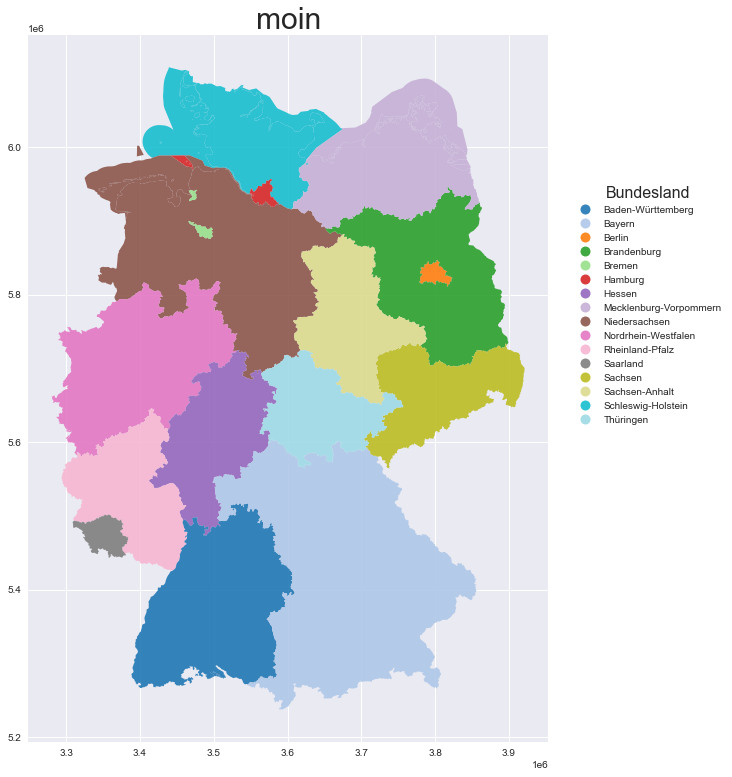

In [10]:
fig, ax = plt.subplots(figsize=(20,13))

shape_df.plot(
    ax=ax, 
    column='GEN', 
    categorical=True, 
    legend=True, 
    legend_kwds={'title':'Bundesland', 'bbox_to_anchor': (1.35, 0.8)},
    cmap='tab20',
    alpha=0.9,
    linewidth=1)
ax.set_title("moin",fontsize=30)
fig.savefig("Karte_der_Bundesländer.png",dpi=300)


In [11]:
def draw_geo_Data(geoDaten,col,vmin=0, vmax=2000,path="ne.png",draw=False):

    fig, ax = plt.subplots(figsize=(13,13))
    geoDaten.plot(
    ax=ax, 
    column=col, 
    categorical=False, 
    legend=True,
    vmin=vmin, vmax=vmax,
    cmap='inferno',
    norm=plt.Normalize(vmin=vmin, vmax=vmax)
    )
    ax.set_title(f"Tag: {col}",fontsize=30)
    ax.set_facecolor('lightblue')
    
    if draw:
        plt.draw()
    plt.close()
    fig.savefig(path,dpi=100)
    #return fig,ax


In [12]:
def draw_geo_Data_week(geoDaten,col,vmin=0, vmax=2000,path="ne.png",draw=False,anfang_titel=""):

    fig, ax = plt.subplots(figsize=(13,13))
    geoDaten.plot(
    ax=ax, 
    column=col, 
    categorical=False, 
    legend=True,
    vmin=vmin, vmax=vmax,
    cmap='inferno',
    norm=plt.Normalize(vmin=vmin, vmax=vmax)
    )
    ax.set_title(f"{anfang_titel}: {col} ",fontsize=30)
    ax.set_facecolor('lightblue')
    
    if draw:
        plt.draw()
    plt.close()
    fig.savefig(path,dpi=100)
    #return fig,ax


In [30]:
def draw_geo_Data_week_bund(fig,ax_geo,ax_plt,geoDaten,col,vmin=0, vmax=2000,path="ne.png",draw=False,anfang_titel="",bund_week=None,index=0):
    geoDaten.plot(
    ax=ax_geo, 
    column=col, 
    categorical=False, 
    legend=True,
    vmin=vmin, vmax=vmax,
    cmap='inferno',
    norm=plt.Normalize(vmin=vmin, vmax=vmax),
    cax=cax_geo
    )
    fig.suptitle(f"{anfang_titel}: {col} ",fontsize=30)
    ax_geo.set_facecolor('lightblue')
    ax_geo.set_title("Karte mit Bundesländern",fontsize=15)
    ax_plt.plot(bund_week[0:index+1],"--")
    ax_plt.set_ylim(0,bund_week.max()*1.05)
    ax_plt.set_xlim(bund_week.index[0],bund_week.index[-1])
    ax_plt.set_title("Inzidenzwert für Deutschland",fontsize=15)

    fig.savefig(path,dpi=100)
    ax_geo.clear()
    ax_plt.clear()
    #return fig,ax


In [34]:
def save(name="img%03d.png",outname="out",fps=5,delete=True):
    os.chdir(r".\img")
    try:
        os.system(f"ffmpeg -framerate {fps} -i {name} -c:v libx264 -vf fps=30 -vb 20M -pix_fmt yuv420p {outname}.mp4")
        shutil.move(f"{outname}.mp4",f"..\\{outname}.mp4")
    finally:
        os.chdir("..")
        if delete:
            shutil.rmtree("img")
            os.mkdir("img")

In [15]:
# i=0
# for date in tqdm(np.flip(datum_list),desc='Progress'):
#     i+=1
#     #path=r".\img"+"\\"+str(date)[:10]+".png"
#     path=r".\img"+"\\"+f'img{i:03}'+".png"
#     draw_geo_Data(geoDaten,date,vmin=0, vmax=max_faelle,path=path)

  0%|          | 0/15 [00:00<?, ?it/s]

4947

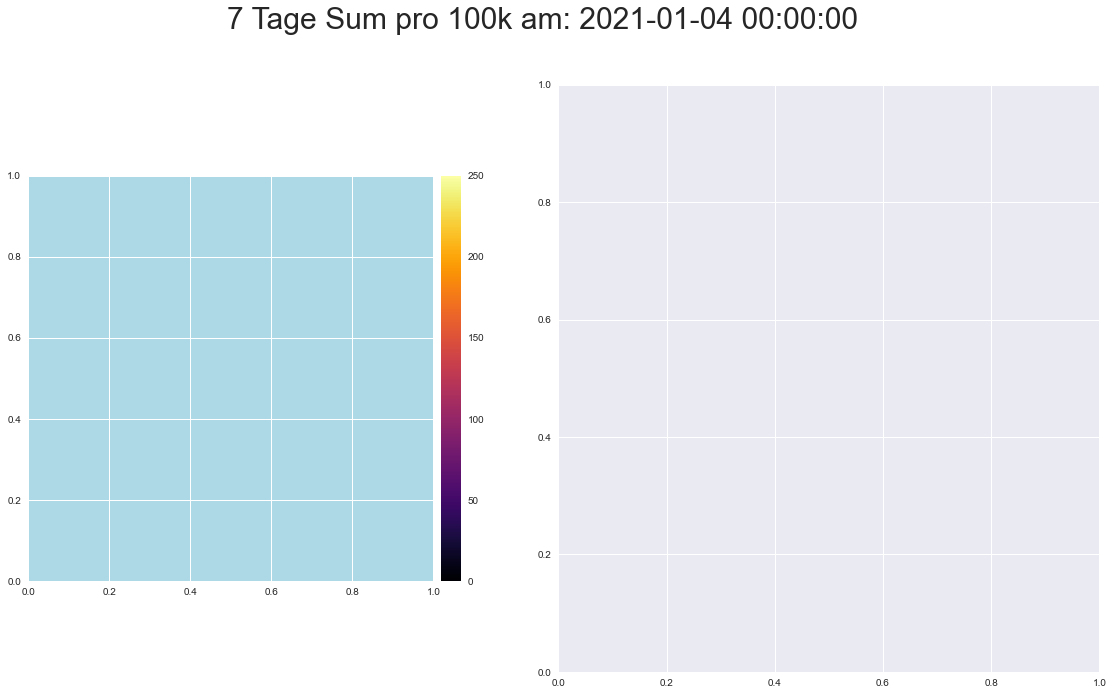

In [35]:
#Figur und Axen einmalig erstellen um sie wiederverwenden zu können
fig, (ax_geo,ax_plt) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1.25]},figsize=(19.2,10.8))
divider = make_axes_locatable(ax_geo)
cax_geo = divider.append_axes("right", size="5%", pad=0.1)


tage=15
datum_list_week,Bundeslaender_week,geoDaten_week,max_faelle_week=gen_geo_Data_week(shape_df,data,tage,scale=True)
bund_week=np.flip(gen_bund_Data_week(data,tage))
datum_list_week_flip=np.flip(datum_list_week)

for i in tqdm(range(tage)):
    path=r".\img"+"\\"+f'imgweek{i:03}'+".png"
    draw_geo_Data_week_bund(fig,ax_geo,ax_plt,geoDaten,datum_list_week_flip[i],
                            vmin=0, vmax=250,path=path,anfang_titel="7 Tage Sum pro 100k am",
                            bund_week=bund_week,index=i)
save(name="imgweek%03d.png",outname="outweek",fps=7.5,delete=True)
gc.collect()